In [15]:
#!/usr/bin/env python3

import sys, getopt
import numpy as np
from math import *
import os
import subprocess
import shlex
import regex as re
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from collections import Counter

%matplotlib widget

def intersection_element(sets, threshold = 0.95):		
    c = Counter()
    for s in sets:
        for elem in s:
            c[elem] += 1
    return [k for k, v in c.items() if v >= len(sets) * threshold]

def sort_lists(A, B, k = 3):
	# Create a list of tuples where each tuple contains an element from A and its index in B
	zipped = list(zip(A, B, range(len(B))))

	# Sort the list of tuples based on the values in B
	zipped.sort(key=lambda x: x[1])

	# Create two separate lists from the sorted list of tuples
	sorted_A = [x[0] for x in zipped]
	indices = [x[2] for x in zipped]

	return sorted_A[:k]

def match_pattern(pattern, line):
	m = []
	matches = re.findall(pattern, line)
	for match in matches:
		m.append(float(match[2:]))
	return m

def average_columns(data):
    # Transpose the 2D list to get the columns as rows
    transposed_data = [[row[i] for row in data] for i in range(len(data[0]))]

    # Calculate the sum of each column and divide by the number of rows
    result = [sum(column) / len(data) for column in transposed_data]

    return result

def intersection_confidence(final_m_values, final_time_values, k_values, threshold_values):
	for k in k_values:
		final_set = set()
		for c in range(len(final_m_values)):
			final_m = sort_lists(final_m_values[c], final_time_values[c], k)
			final_set.add(frozenset(final_m))

		for l in threshold_values:
			values = intersection_element(final_set, l)
			if len(values) != 0:
				print("Common intersection of m values with threshold " + str(l) + " and k values " + str(k), values)

def optimal_values(final_m_values, final_time_values, point_to_compare):
	final_set = []
	for c in range(len(final_m_values)):
		final_m = sort_lists(final_m_values[c], final_time_values[c], 1)[0]
		final_set.append(final_m - point_to_compare)
	return final_set

def plot2d(x,y,thread, threshold, point_to_compare):
	plt.title("Common intersection with threshold {} and point {}".format(threshold, point_to_compare))
	plt.xlabel("Ly values")
	plt.ylabel("Difference between the optimal value and the point to compare")
	plt.plot(x, y, label = "Thread " + str(thread))
	plt.savefig("threshold_" + str(threshold) + "_point_" + str(point_to_compare) + ".png")
	plt.show()

def plot(x,y,z,thread):
	# Create the figure and 3D axis
	fig = plt.figure(figsize = (10,10))
	ax = fig.add_subplot(111, projection='3d')

	# Plot the data
	colors = ['r', 'g', 'b', 'y', 'c', 'm', 'k', 'w'][:len(x)]

	optimal_t = []
	optimal_y = []
	for i in range(len(x)):
		max_time = float(1e5)
		max_m = 0
		for j in range(len(y[i])):
			if max_time > z[i][j]:
				max_m = y[i][j]
				max_time = z[i][j]
		optimal_t.append(max_time)
		optimal_y.append(max_m)

	print("Max upper bound on time:", max(optimal_t),"\n")
	print("Min upper bound on time:", min(optimal_t),"\n")
	print("Average upper bound on time:", sum(optimal_t)/len(optimal_t),"\n")

	print("Max m value:", max(optimal_y),"\n")
	print("Min m value:", min(optimal_y),"\n")
	print("Average m value:", sum(optimal_y)/len(optimal_y),"\n")
	
	for i in range(len(x)):
		ax.scatter(x[i], y[i], z[i], c=colors[i%8], marker='o')
		ax.text(x[i], optimal_y[i], optimal_t[i], "OP", size=10, zorder=1, color='k')
	
	#cb = plt.colorbar(ax1, pad=0.2)

	# Set axis labels
	ax.set_title('Time taken vs Ly and m values')
	#ax.set_xticks(x)
	ax.set_ylabel('m values')
	ax.set_zlabel('time taken values')
	ax.set_xlabel('Ly values')

	# Show the plot
	#plt.savefig("test.png")
	plt.show()

thread = [[],[],[],[],[],[],[],[]]
ly_values = [j for j in range(2,512)]
final_m_values = []
final_time_values = []
t_array = [1]
random_averages = 5

for thread in t_array:
	final_m_values = []
	final_time_values = []
	final_set = set()
	for i in ly_values[1:1]:
		print("Thread ", thread, ": ", end=" ")
		print("Ly=", i, end="\n")
		averaged_columns_m = []
		averaged_columns_time = []
		for k in range(random_averages):
			string = "./hybridconv2 -Lx=512 -Ly=" + str(i) + " -Mx=1024 -My=" + str(2*i) + " -t -R -T=" + str(thread)
			cmd = subprocess.run(shlex.split(string), capture_output=True, text=True)
			string = cmd.stdout

			pattern = "m="
			matches = re.finditer(pattern, string)
			for match in matches:
				# Get the starting index of the match

				start = match.start()
				if int(start) < 100:
					# Get the line number by counting the number of newline characters before the match

					line_num = string[:start].count("\n") + 1
					line_start = string.rfind("\n", 0, start) + 1
					line_end = string.find("Optimal time: ", start)
					line = string[line_start:line_end]
					# Extract the values as a float and append to a list
					m_values = match_pattern("m=\d+", line)
					time_values = match_pattern("t=\d+\.\d+", line)

			averaged_columns_m.append(m_values)
			averaged_columns_time.append(time_values)
		

		final_m_values.append(average_columns(averaged_columns_m))
		final_time_values.append(average_columns(averaged_columns_time))

	print("-------------------------------------------------------")
	#plot(ly_values,final_m_values,final_time_values,thread)
	final_m_values = np.array(final_m_values)
	final_time_values = np.array(final_time_values)
	#np.save("final_m_values", final_m_values)
	#np.save("final_time_values", final_time_values)

-------------------------------------------------------


In [16]:
final_m_values = np.load("final_m_values.npy")
final_time_values = np.load("final_time_values.npy")

In [17]:
print("Final statistics:")
intersection_confidence(final_m_values, final_time_values, [3,5,7], [0.1,0.2,0.3,0.4,0.5,0.6,0.8,0.9])

Final statistics:
Common intersection of m values with threshold 0.1 and k values 3 [1024.0, 512.0, 64.0, 128.0, 4.0, 8.0, 256.0, 32.0, 243.0, 16.0]
Common intersection of m values with threshold 0.2 and k values 3 [1024.0, 512.0, 64.0, 128.0, 4.0, 8.0, 32.0, 16.0]
Common intersection of m values with threshold 0.3 and k values 3 [512.0, 64.0, 128.0, 32.0]
Common intersection of m values with threshold 0.4 and k values 3 [64.0, 32.0]
Common intersection of m values with threshold 0.1 and k values 5 [64.0, 32.0, 128.0, 8.0, 16.0, 256.0, 4.0, 512.0, 243.0, 125.0, 2.0, 81.0, 1024.0]
Common intersection of m values with threshold 0.2 and k values 5 [64.0, 32.0, 128.0, 8.0, 16.0, 256.0, 4.0, 512.0, 243.0, 1024.0]
Common intersection of m values with threshold 0.3 and k values 5 [64.0, 32.0, 128.0, 8.0, 16.0, 4.0, 512.0]
Common intersection of m values with threshold 0.4 and k values 5 [64.0, 32.0, 128.0, 8.0, 16.0, 512.0]
Common intersection of m values with threshold 0.5 and k values 5 [64

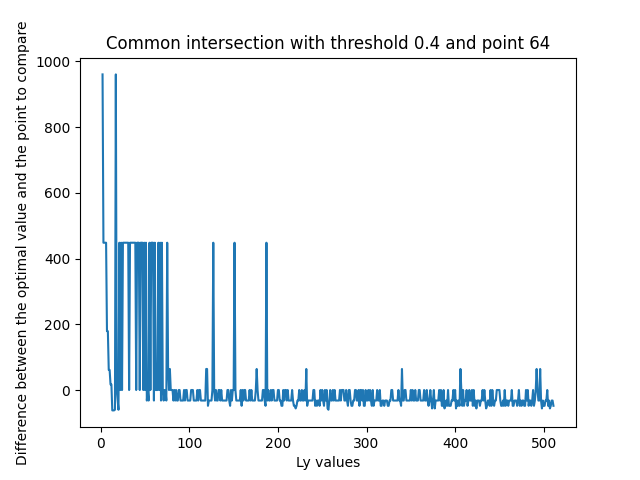

In [18]:
plot2d(ly_values, optimal_values(final_m_values, final_time_values, 64), thread = 1, threshold = 0.4, point_to_compare = 64)
#plot2d(ly_values, optimal_values(final_m_values, final_time_values, 32), thread = 1, threshold = 0.4, point_to_compare = 32)